## Load Required Libraries

In [3]:
### Import required libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from IPython.display import display # Allows the use of display() for DataFrames

import warnings
warnings.filterwarnings('ignore')

## Load Train and Test Data

In [4]:
# Read train and test files
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

### Train Data

In [5]:
train_df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


### Test Data

In [6]:
test_df.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train and Test Data Info

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


## Check for Missing Values

In [9]:
#### Check if there are any NULL values in Train Data
print("Total Train Features with NaN Values = " + str(train_df.columns[train_df.isnull().sum() != 0].size))
if (train_df.columns[train_df.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(train_df.columns[train_df.isnull().sum() != 0])))
    train_df[train_df.columns[train_df.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Train Features with NaN Values = 0


In [10]:
#### Check if there are any NULL values in Test Data
print("Total Test Features with NaN Values = " + str(test_df.columns[test_df.isnull().sum() != 0].size))
if (test_df.columns[test_df.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(test_df.columns[test_df.isnull().sum() != 0])))
    test_df[test_df.columns[test_df.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Test Features with NaN Values = 0


## Build Train and Test Data for Modeling

In [11]:
X_train = train_df.drop(["ID", "target"], axis=1)
y_train = np.log1p(train_df["target"].values)

X_test = test_df.drop(["ID"], axis=1)

In [12]:
dev_X, val_X, dev_y, val_y = train_test_split(X_train, y_train, test_size = 0.2, random_state = 23)

## LightGBM
Light gradient boosting machine documentation: [LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

In [14]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 42,
        "verbosity" : 1,
        "random_seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=50, 
                      evals_result=evals_result)
    
    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result

In [15]:
# Training LGB
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, X_test)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 1.62433
[100]	valid_0's rmse: 1.56358
[150]	valid_0's rmse: 1.5189
[200]	valid_0's rmse: 1.48481
[250]	valid_0's rmse: 1.4595
[300]	valid_0's rmse: 1.44091
[350]	valid_0's rmse: 1.42608
[400]	valid_0's rmse: 1.41539
[450]	valid_0's rmse: 1.4076
[500]	valid_0's rmse: 1.40253
[550]	valid_0's rmse: 1.39931
[600]	valid_0's rmse: 1.39732
[650]	valid_0's rmse: 1.3958
[700]	valid_0's rmse: 1.39532
[750]	valid_0's rmse: 1.39559
[800]	valid_0's rmse: 1.39563
Early stopping, best iteration is:
[724]	valid_0's rmse: 1.39504
LightGBM Training Completed...


In [16]:
# feature importance
print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:15])

Features Importance...
        feature      gain  split
4358  f190486d6  7.739803    600
2500  58e2e02e6  5.444183    538
3660  eeb9cd3aa  2.605373    396
4243  15ace8c9f  1.781273    384
1530  b43a7cfd5  1.689236    346
2755  9fd594eec  1.511255    231
3771  58232a6fb  1.500749    244
8     20aa07010  1.409012    224
4084  2288333b4  1.369264    181
878   6eef030c1  1.346504    279
3866  491b9ee45  1.339340    223
4758  c47340d97  1.280449    245
1815  9306da53f  1.222382    141
1556  024c577b9  1.159613    210
3928  d6bb78916  1.020888    263


## XGB Modeling

In [18]:
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.005,
          'max_depth': 10, 
          'subsample': 0.7, 
          'colsample_bytree': 0.5,
          'alpha':0,
          'random_state': 23, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 10, verbose_eval=10)
    
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))
    
    return xgb_pred_y, model_xgb

In [19]:
# Training XGB
pred_test_xgb, model_xgb = run_xgb(dev_X, dev_y, val_X, val_y, X_test)
print("XGB Training Completed...")

[0]	train-rmse:14.0251	valid-rmse:14.0496
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[10]	train-rmse:13.3503	valid-rmse:13.3749
[20]	train-rmse:12.7095	valid-rmse:12.734
[30]	train-rmse:12.0997	valid-rmse:12.1248
[40]	train-rmse:11.5207	valid-rmse:11.5463
[50]	train-rmse:10.9702	valid-rmse:10.9962
[60]	train-rmse:10.4472	valid-rmse:10.4741
[70]	train-rmse:9.95036	valid-rmse:9.97795
[80]	train-rmse:9.47821	valid-rmse:9.50672
[90]	train-rmse:9.02964	valid-rmse:9.0589
[100]	train-rmse:8.60311	valid-rmse:8.63379
[110]	train-rmse:8.19792	valid-rmse:8.23031
[120]	train-rmse:7.8132	valid-rmse:7.84767
[130]	train-rmse:7.44795	valid-rmse:7.4843
[140]	train-rmse:7.10114	valid-rmse:7.13986
[150]	train-rmse:6.7711	valid-rmse:6.81267
[160]	train-rmse:6.4583	valid-rmse:6.50215
[170]	train-rmse:6.16093	valid-rmse:6.20765
[180]	train-rmse:5.87846	valid-rmse:5.92818
[190]	train-rmse:5.60999	valid-rmse:

In [23]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [30.0,16.0]
plt.rcParams['figure.dpi']=80
plt.rcParams.update({'font.size': 24})

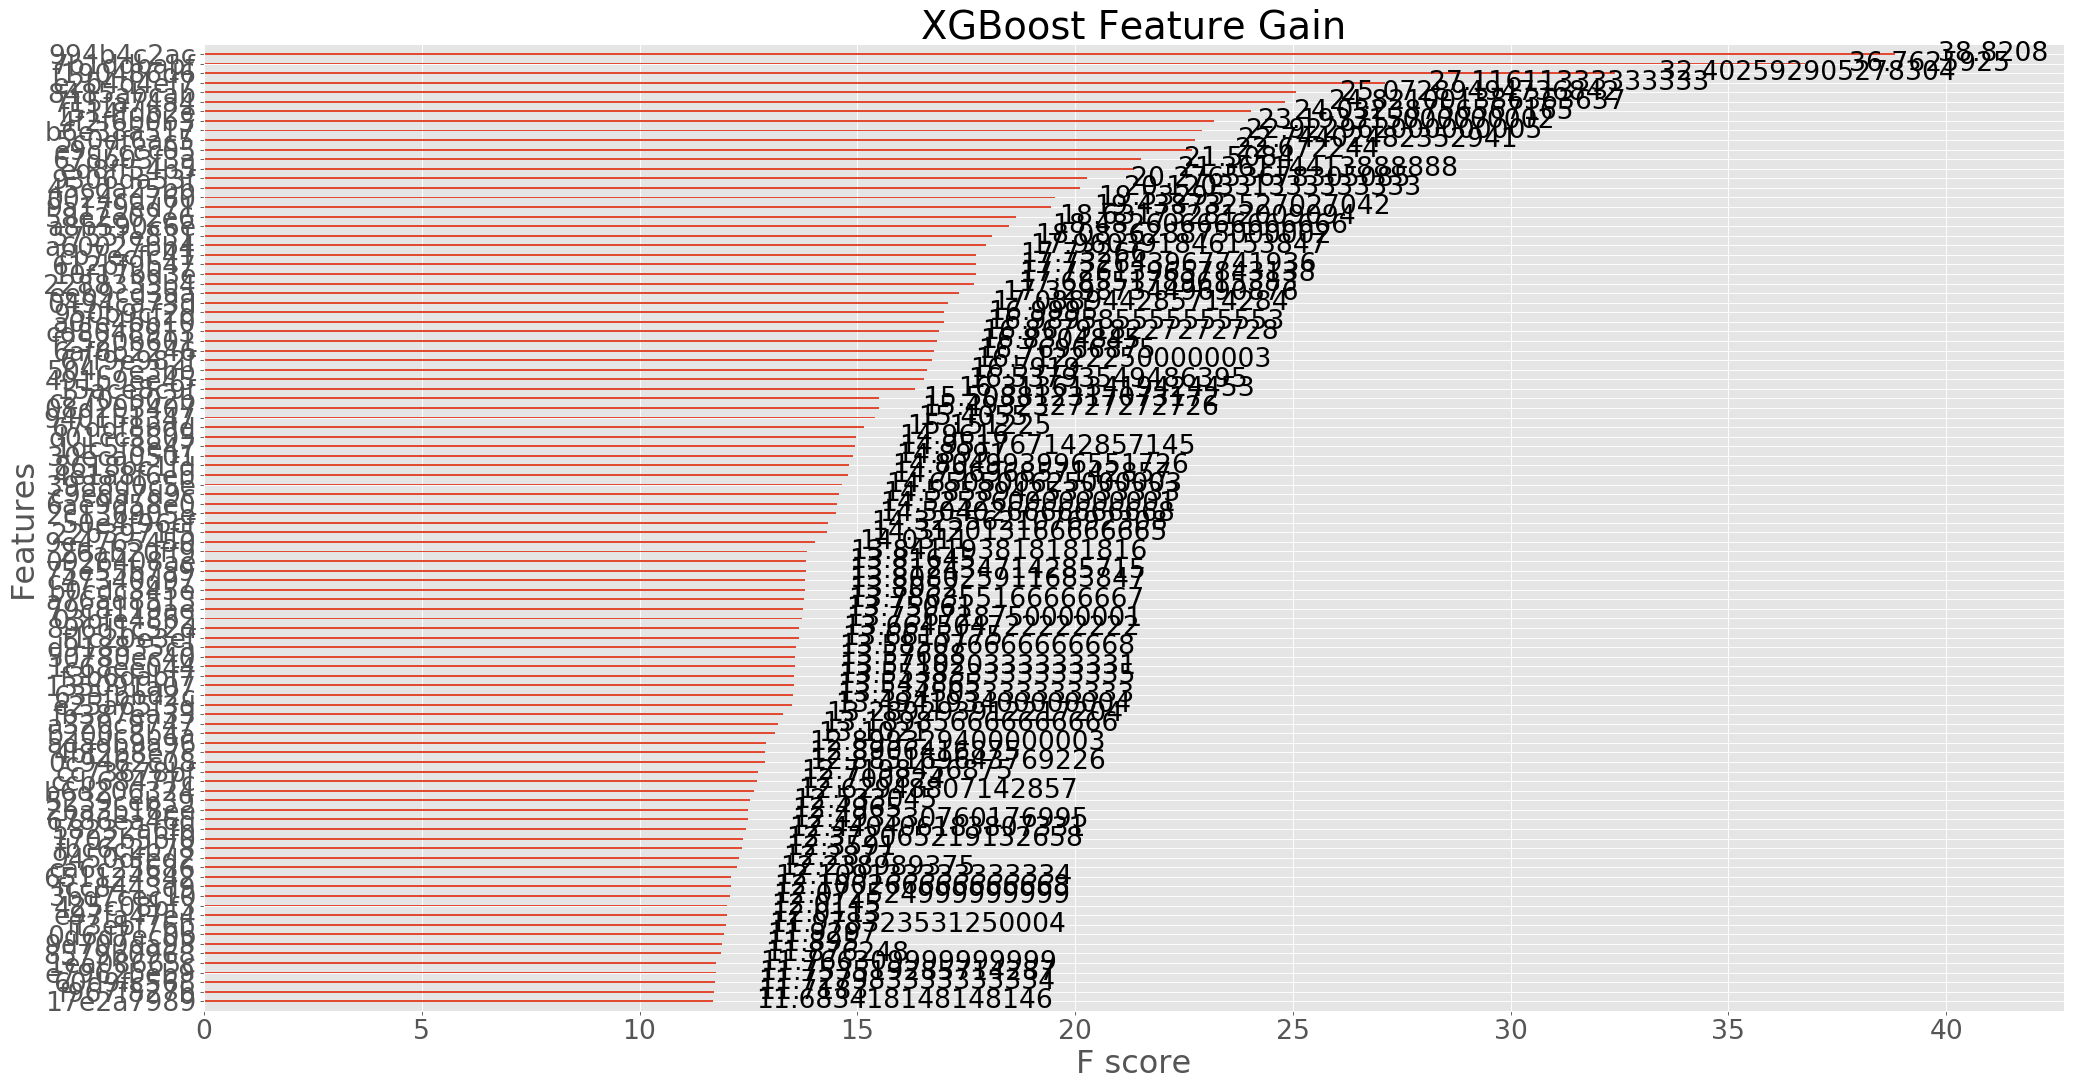

In [24]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(model_xgb, importance_type="gain", max_num_features=100)
plt.title("XGBoost Feature Gain")
plt.show()

## Combine Predictions

In [29]:
predLGB = pd.DataFrame(pred_test)
predLGB.head()

,0
0,1.870464e+06
1,1.853537e+06
2,1.507575e+06
3,5.109954e+06
4,1.951425e+06


In [31]:
sub = pd.read_csv('../input/sample_submission.csv')

In [33]:
sub.head()

,ID,target
0,000137c73,5.944923e+06
1,00021489f,5.944923e+06
2,0004d7953,5.944923e+06
3,00056a333,5.944923e+06
4,00056d8eb,5.944923e+06


In [34]:
sub_lgb = pd.DataFrame()
sub_lgb["target"] = pred_test
sub_xgb = pd.DataFrame()
sub_xgb["target"] = pred_test_xgb

## My usual f*cking ensemble


In [48]:
ensemble = sub_lgb.copy()
ensemble.rename(columns={'target':'LGB'}, inplace=True)
ensemble['XGB']=sub_xgb['target']
ensemble['ens'] = (sub_lgb["target"] + sub_xgb["target"])/2

In [49]:
ensemble.head()

,LGB,XGB,ens
0,1.870464e+06,2096686.125,1.983575e+06
1,1.853537e+06,1691738.000,1.772637e+06
2,1.507575e+06,2031116.125,1.769346e+06
3,5.109954e+06,5127224.000,5.118589e+06
4,1.951425e+06,1756507.375,1.853966e+06


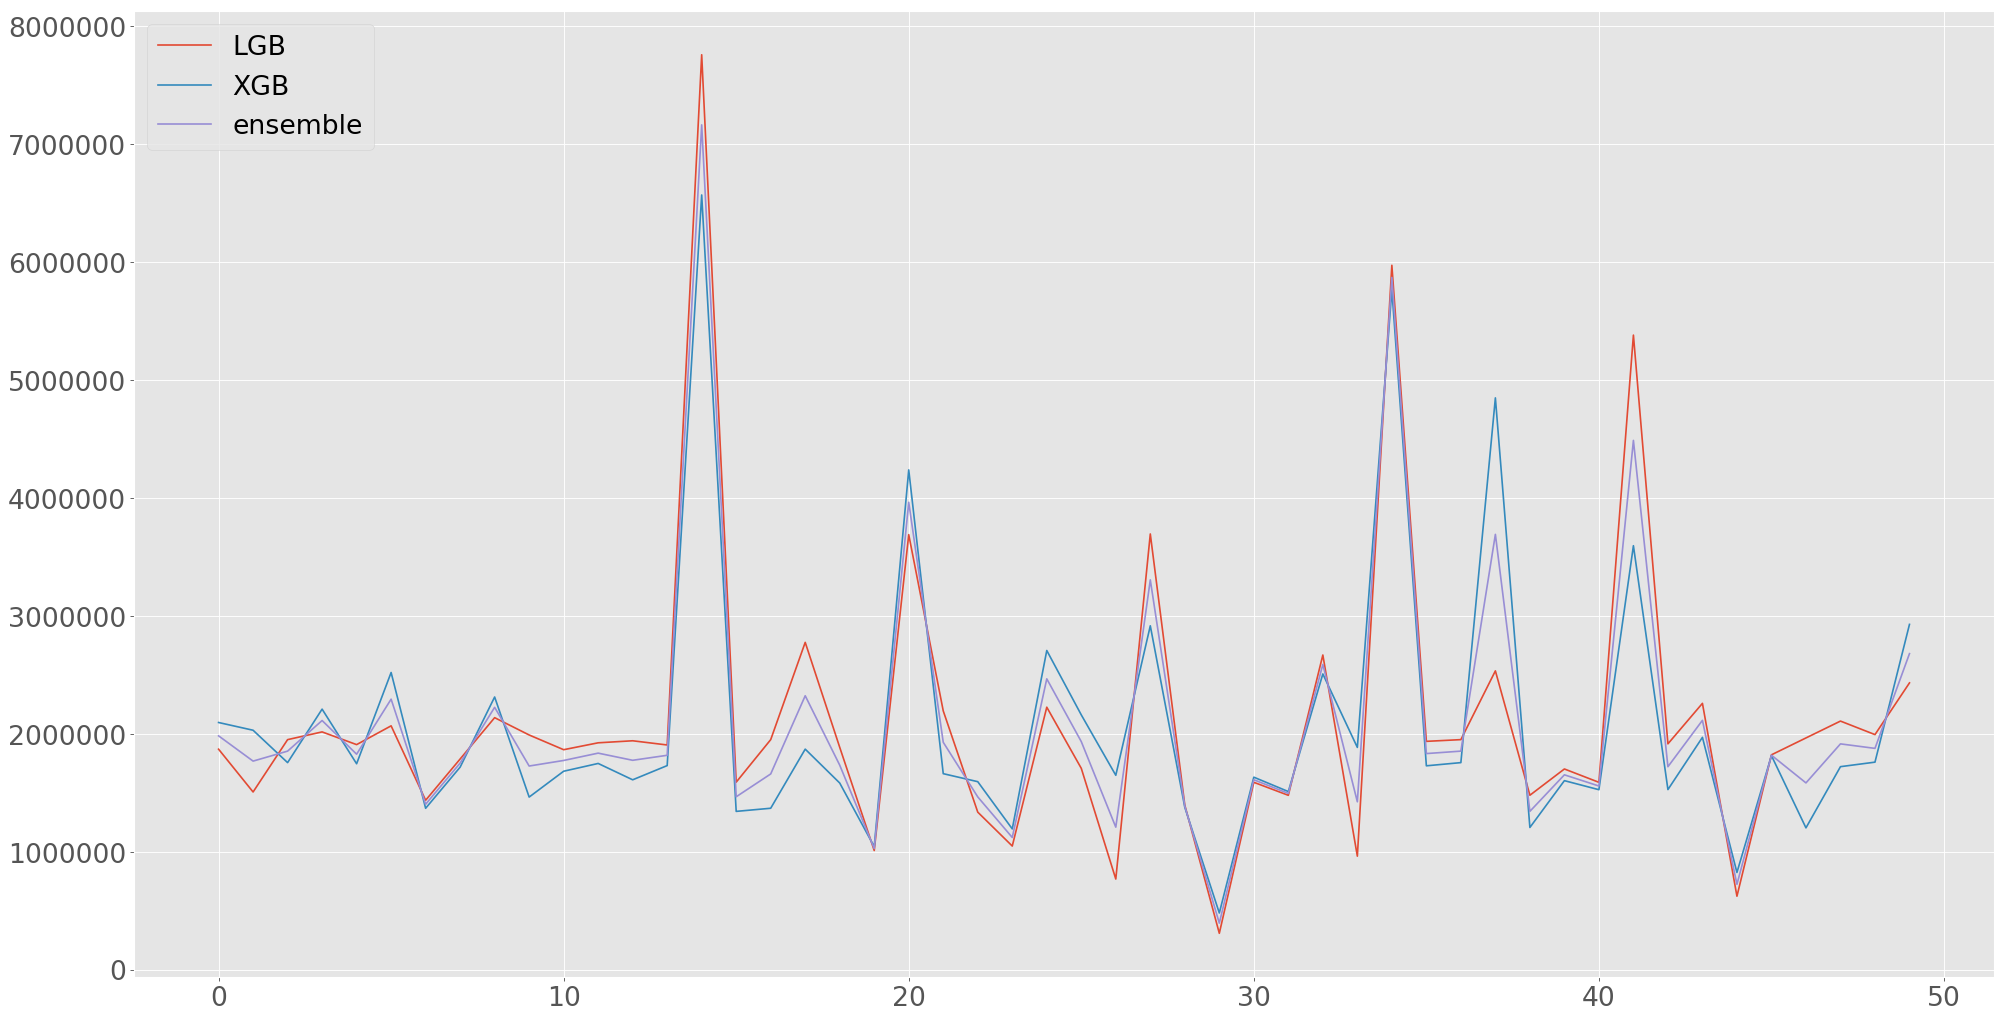

In [51]:
import matplotlib.pyplot as plt
start=0
end=100
yhat = ensemble.iloc[start:end:2].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['LGB', 'XGB','ensemble'], loc='upper left')
plt.show()

In [57]:
sub['target']=ensemble['ens']
sub.head()

,ID,target
0,000137c73,1.983575e+06
1,00021489f,1.772637e+06
2,0004d7953,1.769346e+06
3,00056a333,5.118589e+06
4,00056d8eb,1.853966e+06


In [58]:
sub.to_csv('sub_lgb_xgb_ens.csv', index=False)

In [61]:
! kaggle competitions submit -c santander-value-prediction-challenge -f sub_lgb_xgb_ens.csv -m "lgb_xgb_ens submission1"

Successfully submitted to Santander Value Prediction Challenge
